### Imports

In [56]:
#from torchdata.datapipes.iter import IterableWrapper, S3FileLoader # !pip install torchdata
#from torch.utils.data import Dataset,DataLoader
import torchvision
from PIL import Image
#import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
#from torchvision import transforms
import torchvision.ops as ops
import pandas as pd

import torch
import torch.nn as nn

import pickle as pkl
from contextlib import closing

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Data

In [100]:
with closing((open('detection/LARD/lard_nfm_data_iou.pkl', 'rb'))) as f:
             dico_dataset = pkl.load(f)

X_train = dico_dataset['x_train']
X_test = dico_dataset['x_test']
Y_train = dico_dataset['y_train']
Y_test = dico_dataset['y_test']

X_train_ = torch.Tensor(X_train).to(device)
X_test_ = torch.Tensor(X_test).to(device)
Y_train_ = torch.Tensor(Y_train).to(device)
Y_test_ = torch.Tensor(Y_test).to(device)

In [101]:
dico_dataset

{'x_train': array([[[[107, 107, 107, ...,  86,  86,  86],
          [108, 108, 107, ...,  86,  86,  86],
          [108, 108, 108, ...,  87,  87,  86],
          ...,
          [119, 129, 136, ...,  97,  95,  91],
          [135, 137, 151, ..., 109, 111, 113],
          [135, 140, 167, ..., 127, 125, 126]],
 
         [[159, 159, 159, ..., 133, 133, 133],
          [160, 160, 159, ..., 133, 132, 133],
          [160, 160, 160, ..., 134, 134, 133],
          ...,
          [105, 119, 128, ...,  85,  87,  84],
          [124, 126, 141, ...,  88,  93,  92],
          [123, 127, 155, ..., 101, 100, 100]],
 
         [[234, 234, 234, ..., 216, 216, 215],
          [234, 234, 234, ..., 216, 216, 216],
          [235, 235, 235, ..., 216, 216, 215],
          ...,
          [103, 112, 117, ...,  88,  90,  87],
          [114, 116, 130, ...,  92,  95,  95],
          [114, 118, 147, ..., 103, 101, 101]]],
 
 
        [[[ 93,  93,  93, ..., 114, 115, 115],
          [ 94,  94,  94, ..., 115, 115

In [131]:
from torch.utils.data import DataLoader

dataloader = DataLoader(X_train, batch_size=1, shuffle=False)
iterator = iter(dataloader)
dataloader_Y = DataLoader(Y_train, batch_size=1, shuffle=False)
iterator_Y = iter(dataloader_Y)

In [132]:
data_Y.shape

torch.Size([1, 4])

In [133]:
data = next(iterator)
data_Y = next(iterator_Y)
X = data/255
y = data_Y*256

In [134]:

y

tensor([[135.2157, 122.8761, 140.0261, 125.4864]])

tensor([[[ 95.,  95.,  95.,  ...,  88.,  88.,  88.],
         [ 96.,  96.,  96.,  ...,  88.,  88.,  88.],
         [ 96.,  96.,  96.,  ...,  89.,  89.,  89.],
         ...,
         [163., 166., 169.,  ..., 195., 189., 183.],
         [158., 159., 161.,  ..., 204., 202., 194.],
         [147., 147., 150.,  ..., 206., 203., 196.]],

        [[144., 144., 144.,  ..., 135., 135., 135.],
         [145., 145., 145.,  ..., 135., 135., 135.],
         [145., 145., 145.,  ..., 136., 136., 136.],
         ...,
         [140., 143., 144.,  ..., 184., 179., 172.],
         [138., 139., 140.,  ..., 191., 187., 177.],
         [137., 137., 139.,  ..., 189., 185., 176.]],

        [[223., 223., 223.,  ..., 217., 217., 217.],
         [224., 224., 224.,  ..., 217., 217., 217.],
         [224., 224., 224.,  ..., 218., 218., 218.],
         ...,
         [128., 131., 132.,  ..., 165., 160., 153.],
         [126., 126., 127.,  ..., 175., 172., 161.],
         [121., 121., 123.,  ..., 174., 171., 164.]]]

In [138]:
bound_whitenoise(torch_model, X_train_[52][None]/255, 0.000, method='crown')

(array([ 65.37699 , 119.904785,  68.43369 , 123.424866], dtype=float32),
 array([ 65.37699 , 119.904785,  68.43369 , 123.424866], dtype=float32))

In [140]:
Y_train_[52]*256

tensor([ 64.8366, 118.4290,  67.3464, 121.7160])

In [59]:
# convert the data into tensors and send it to the right device


In [60]:
len(X_train_)

400

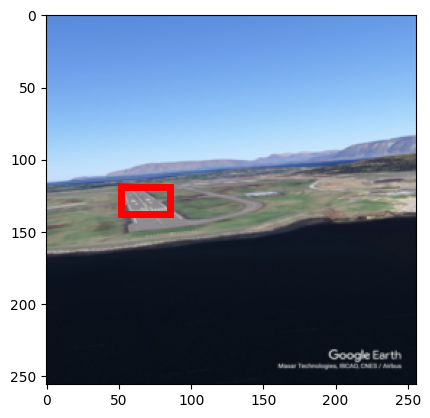

In [61]:
### plot

img_ = np.transpose(X_test[0], (1, 2, 0))

fig, ax = plt.subplots()
ax.imshow(img_)

# all the groundtruth coordinates are normalized, we need to rescale it to 256
x_0, y_0, x_1, y_1 = [e*256 for e in Y_test[0]]

rect = patches.Rectangle(
            (x_0, y_0),
            x_1-x_0, y_1-y_0, 
            linewidth=5, edgecolor='r', facecolor="none") 
ax.add_patch(rect)


plt.show()

# load model

In [62]:
torch_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=(3,3), stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(), #131072
    nn.Linear(131072, 128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128,4),
)

In [63]:
if device.type=='cuda':
    torch_model.cuda()

In [64]:
## load previous saved model

nnet = torch.load('detection/weights/tmp_nfm_v4.pt', torch.device('cpu'))

In [65]:
torch_model.load_state_dict(nnet.state_dict())

<All keys matched successfully>

In [66]:
img_[None].shape

(1, 256, 256, 3)

In [67]:
torch_im.permute(2,0,1)[None].shape

torch.Size([1, 3, 256, 256])

In [68]:
torch_im = torch.tensor(img_).to(torch.float32)
torch_model(torch_im.permute(2,0,1)[None])

tensor([[29357.2363, 31679.2734, 31448.5527, 33000.0234]],
       grad_fn=<AddmmBackward0>)

## Check IOU

In [69]:
loss_iou = ops.distance_box_iou_loss

In [70]:
X_train_.shape

torch.Size([400, 3, 256, 256])

In [71]:
outputs = torch_model(X_train_/255.)

In [72]:
ious = loss_iou(Y_train_*256, outputs)

In [104]:
index_iou_train =  torch.where(ious<0.5)[0].cpu().numpy()

mean_ious = torch.mean(ious)
print('index of correct ious', index_iou_train)
print('mean test ious', mean_ious)

index of correct ious [185 197 198 202 203 205 206 209 210 211 212 213 214 216 218 220 221 222
 224 226 227 229 230 231 232 233 239 240 241 242 243 244 245 246 247 248
 249 250 251 252 253 254 255 258 259 260 261 262 263 264 265 266 267 269
 270 271 272 273 274 275 277 278 279 281 282 284 285 286 287 288 289 290
 291 292 293 294 295 296 297 298 299 300 301 302 304 305 306 307 308 310
 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328
 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346
 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399]
mean test ious tensor(0.5682, grad_fn=<MeanBackward0>)


In [144]:
i = index_iou_train[np.random.permutation(len(index_iou_train))][0]
i

301

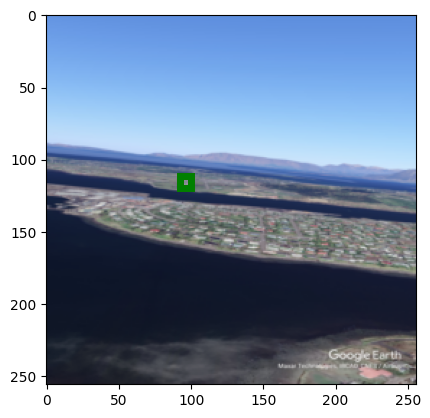

In [105]:
### plot
i = index_iou_train[np.random.permutation(len(index_iou_train))][0]
img_ = np.transpose(X_train[i], (1, 2, 0))

fig, ax = plt.subplots()
ax.imshow(img_)

# all the groundtruth coordinates are normalized, we need to rescale it to 256
x_0_gt, y_0_gt, x_1_gt, y_1_gt = [e*256 for e in Y_train[i]]
x_0_p, y_0_p, x_1_p, y_1_p = [e*256 for e in Y_train[i]]

rect_gt = patches.Rectangle(
            (x_0_gt, y_0_gt),
            x_1_gt-x_0_gt, y_1_gt-y_0_gt, 
            linewidth=5, edgecolor='r', facecolor="none") 
ax.add_patch(rect_gt)

rect_p = patches.Rectangle(
            (x_0_p, y_0_p),
            x_1_p-x_0_p, y_1_p-y_0_p, 
            linewidth=5, edgecolor='g', facecolor="none") 
ax.add_patch(rect_p)


plt.show()

In [107]:
Y_train[i].shape

(4,)

In [78]:
def bound_whitenoise(model_box, X, eps, method='crown'):
    X_lirpa = X.float().to('cpu')
    model_lirpa_corner = BoundedModule(model_box, X_lirpa)
    ptb = PerturbationLpNorm(norm=np.inf, eps=eps)
    input_lirpa = BoundedTensor(X_lirpa, ptb)
    lb_box, ub_box = model_lirpa_corner.compute_bounds(x=(input_lirpa,),method=method)
    return lb_box.detach().numpy()[0], ub_box.detach().numpy()[0]



In [76]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm
import numpy as np
import torch 
import pandas as pd
import torch.nn.functional as F
from torch import nn


bound_whitenoise(torch_model, torch_im.permute(2,0,1)[None]/255, 0.0002, method='crown')

(array([ 56.074974, 117.21887 ,  88.685036, 133.3083  ], dtype=float32),
 array([ 57.756607, 118.04462 ,  90.36452 , 134.20847 ], dtype=float32))

In [77]:
torch_im.permute(2,0,1)[None].shape

torch.Size([1, 3, 256, 256])

In [118]:
torch_model(X_train_[i][None]/255.)

tensor([[ 93.3464, 112.5051, 100.9680, 120.6756]], grad_fn=<AddmmBackward0>)

In [121]:
Y_train_[i]*256

tensor([ 92.3399, 111.3716,  99.7647, 119.5891])

In [119]:
bound_whitenoise(torch_model, X_train_[i][None]/255., 0.0002, method='crown')

(array([ 92.49625, 112.10933, 100.12429, 120.23955], dtype=float32),
 array([ 94.19751, 112.90226, 101.8129 , 121.11319], dtype=float32))

tensor([[[ 78.,  78.,  77.,  ...,  79.,  80.,  80.],
         [ 79.,  79.,  79.,  ...,  80.,  80.,  80.],
         [ 78.,  78.,  78.,  ...,  80.,  80.,  79.],
         ...,
         [ 73.,  68.,  63.,  ...,  63.,  58.,  86.],
         [ 66.,  72.,  85.,  ...,  89.,  57.,  56.],
         [ 94.,  93.,  95.,  ..., 103.,  73.,  45.]],

        [[119., 119., 119.,  ..., 119., 119., 119.],
         [119., 118., 118.,  ..., 119., 119., 119.],
         [120., 120., 120.,  ..., 119., 119., 120.],
         ...,
         [ 78.,  74.,  72.,  ...,  65.,  67., 104.],
         [ 74.,  79.,  93.,  ...,  91.,  61.,  66.],
         [ 95.,  93.,  94.,  ..., 106.,  77.,  52.]],

        [[196., 196., 195.,  ..., 196., 196., 196.],
         [197., 197., 197.,  ..., 196., 196., 197.],
         [196., 196., 196.,  ..., 198., 197., 197.],
         ...,
         [ 65.,  61.,  58.,  ...,  48.,  49.,  85.],
         [ 62.,  68.,  81.,  ...,  72.,  42.,  46.],
         [ 88.,  86.,  88.,  ...,  90.,  62.,  38.]]]

In [146]:
df = pd.read_csv("/Users/ncohmpli/Documents/Professionnel/Technical/Verification/Lirpa for IoU/manip/pipeline/lirpa_iou_pipeline/results/LARD/grrr.csv")

In [153]:
df = df.loc[[0]].transpose().reset_index().drop(0)

In [156]:
df = df.rename(columns={0:"IoU_extension"})

In [163]:
df["index"] = df["index"].apply(lambda x: float(x))

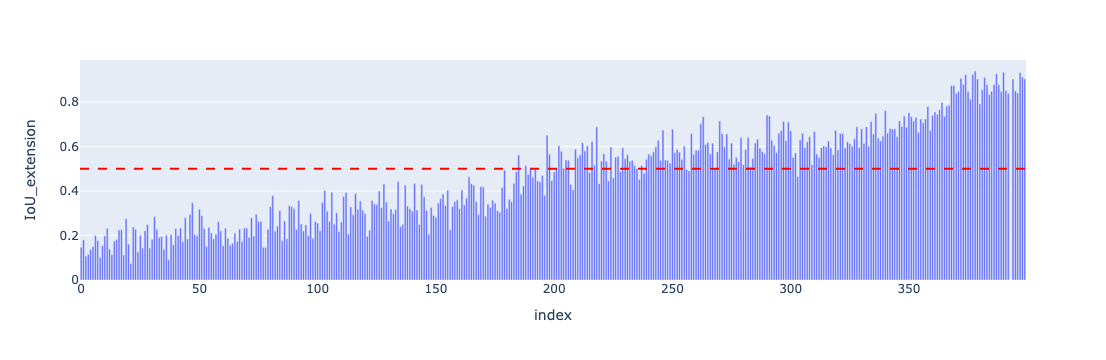

In [166]:
import plotly.express as px
fig = px.bar(df, x="index", y="IoU_extension")
fig.add_hline(y=0.5, line_dash="dash", line_color="red")
fig.show()